In [1]:
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 MB 816.7 kB/s eta 0:00:000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 KB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 7.3 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 5.4 MB/s eta 0:00:0000:01


In [1]:
from pynq_dpu import DpuOverlay
import numpy as np
import cv2
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
overlay = DpuOverlay("dpu.bit")
overlay.load_model("adam_100_da_best_quantized.xmodel")

In [3]:
IMG_PATH = "5.jpg"

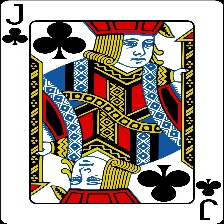

In [4]:
Image(IMG_PATH)

In [5]:
df = pd.read_csv('cards.csv')
label_encoder = LabelEncoder()
df["encoded_labels"] = label_encoder.fit_transform(df["labels"])
label_mapping = dict(zip(label_encoder.classes_,range(len(label_encoder.classes_))))
class_names = list(label_mapping.keys())

In [6]:
dpu = overlay.runner

In [7]:
inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

In [8]:
print(inputTensors)
print(inputTensors[0].dims)
print(inputTensors[0].dtype)

[<xir.Tensor named 'quant_conv2d_input'>]
[1, 128, 128, 3]
xint8


In [9]:
print(outputTensors)
print(outputTensors[0].dims)
print(outputTensors[0].dtype)

[<xir.Tensor named 'quant_dense_1_softmax_fix'>]
[1, 53]
xint8


In [10]:
fix_point = dpu.get_input_tensors()[0].get_attr("fix_point")
print(fix_point)

6


In [11]:
# input buffer
inputDim = tuple(dpu.get_input_tensors()[0].dims)
inputData = [np.empty(inputDim, dtype=np.int8)]

In [ ]:
# input image
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (128, 128))

In [13]:
# normalization
image = resized_image/255.0

In [14]:
# quantization
fix_point = dpu.get_input_tensors()[0].get_attr("fix_point")
scale = 2 ** fix_point
image = (image * scale).round()
image = image.astype(np.int8)

In [15]:
inputData[0][0] = image

In [19]:
outputDim = tuple(dpu.get_output_tensors()[0].dims)
outputData = [np.empty(outputDim, dtype=np.int8)]

In [20]:
%%time
job_id = dpu.execute_async(inputData, outputData)
dpu.wait(job_id)

CPU times: user 2.63 ms, sys: 146 µs, total: 2.78 ms
Wall time: 2 ms


0

In [21]:
print(outputData[0][0])

[-33 -49 -46 -36 -14 -40 -40 -29  -8 -34 -35 -19  -4 -31 -29 -16  15  -9
  -8   3 -12  -2 -24 -16 -17 -20 -38 -34 -23  -6 -19 -29 -10 -14 -26 -32
 -22  -1 -43 -38  -4 -18 -42 -44 -35  -8 -25 -43 -21 -20 -36 -26 -20]


In [22]:
class_idx = outputData[0][0].argmax()

In [23]:
print("Your card is " + str(class_names[class_idx]) + ".")

Your card is jack of clubs.


In [24]:
def visualize_predictions(original_image, probabilities):
    plt.figure(figsize=(10, 8))  # Increased figure height for better spacing

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis("off")

    # Show probabilities
    plt.subplot(1, 2, 2)
    y_positions = np.arange(len(class_names))
    plt.barh(y_positions, probabilities, align="center")

    # Increase spacing
    plt.yticks(y_positions, class_names, fontsize=8)  # Reduce font size for better readability
    plt.gca().invert_yaxis()  # Keep highest probability at the top
    plt.xlabel("Probability")
    plt.title("Class Predictions")

    plt.tight_layout()
    plt.show()

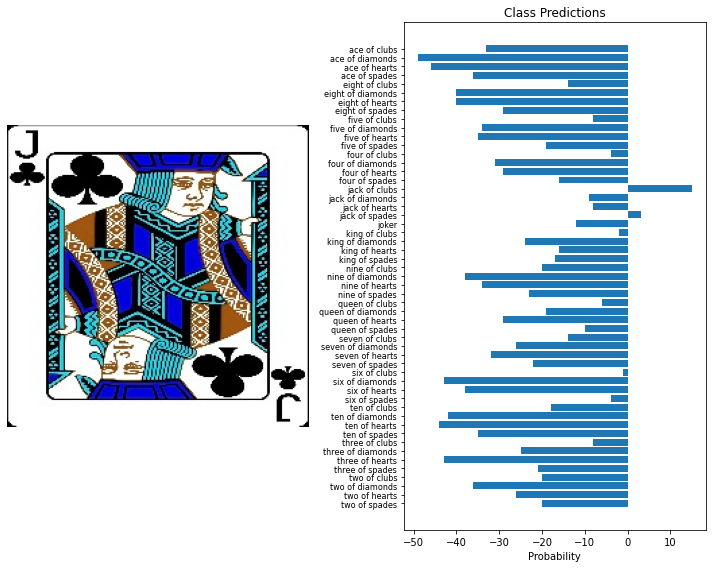

In [25]:
original_image = cv2.imread(IMG_PATH)
visualize_predictions(original_image, outputData[0][0])